In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [3]:

spy = pd.read_csv('../input/s-p-500-dataset/spy.csv')

spy['Date'] = pd.to_datetime(spy['Date'])

series = spy['Close']


train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']


test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']


valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 7028


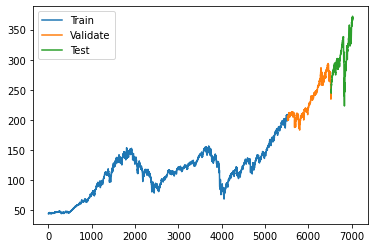

In [4]:
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [5]:
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)


x_train_scaler = MinMaxScaler(feature_range=(0, 1))


normalized_x_train = x_train_scaler.fit_transform(x_train_values)


normalized_x_valid = x_train_scaler.transform(x_valid_values)


normalized_x_test = x_train_scaler.transform(x_test_values)


spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

In [6]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [7]:

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)


model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])


optimizer = keras.optimizers.Nadam(lr=1e-4)


model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


reset_states = ResetStatesCallback()


model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

2022-07-01 10:38:01.048152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 10:38:01.168361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 10:38:01.169480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 10:38:01.170935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/500


2022-07-01 10:38:09.457370: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


184/184 [==============================] - 9s 16ms/step - loss: 2.7607e-04 - mae: 0.0178 - val_loss: 0.0014 - val_mae: 0.0419


2022-07-01 10:38:18.272807: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/500
184/184 [==============================] - 2s 12ms/step - loss: 3.7433e-04 - mae: 0.0192 - val_loss: 0.0013 - val_mae: 0.0383
Epoch 3/500
184/184 [==============================] - 2s 11ms/step - loss: 1.9934e-04 - mae: 0.0150 - val_loss: 0.0013 - val_mae: 0.0392
Epoch 4/500
184/184 [==============================] - 2s 12ms/step - loss: 1.7524e-04 - mae: 0.0139 - val_loss: 0.0014 - val_mae: 0.0405
Epoch 5/500
184/184 [==============================] - 2s 11ms/step - loss: 1.6423e-04 - mae: 0.0134 - val_loss: 0.0015 - val_mae: 0.0417
Epoch 6/500
184/184 [==============================] - 2s 10ms/step - loss: 1.5508e-04 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0432
Epoch 7/500
184/184 [==============================] - 2s 11ms/step - loss: 1.4680e-04 - mae: 0.0126 - val_loss: 0.0018 - val_mae: 0.0458
Epoch 8/500
184/184 [==============================] - 2s 12ms/step - loss: 1.3921e-04 - mae: 0.0123 - val_loss: 0.0021 - val_mae: 0.0505
Epoch 9/500
184/184 [=============

In [8]:

model = keras.models.load_model("my_checkpoint")

In [9]:
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(501,)

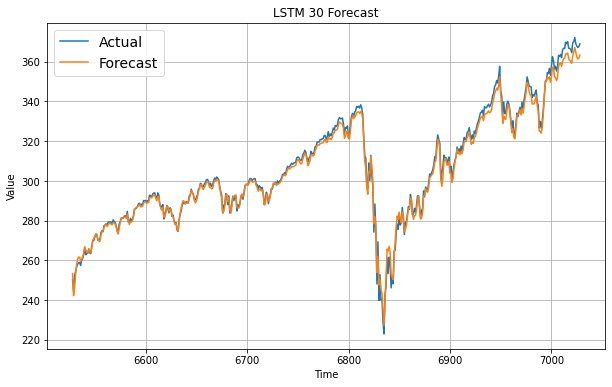

1.982235

In [10]:
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()